# analyze `allblocks-quorum-istanbul.db` data

calculates & plots

* blocktime
* TPS (transactions per second), over 1, 3, 5, 10 consecutive blocks
* block size
* gasUsed and gasLimit per second

It needs an `allblocks-quorum-istanbul.db` database (created by `blocksDB_create.py`) containing all the blocks.

In this specific case the "Quorum" client of the EEA, and the `IBFT` variant.

---

Please cite this as:

> Ethereum benchmarking scripts "chainhammer" and "chainreader"  
> by Dr Andreas Krueger, Electron.org.uk, London 2018  
> https://github.com/drandreaskrueger/chainhammer    

Consider to submit your improvements & usage as pull request --> [../other-projects.md](../other-projects.md).  Thanks.


---

<a id='chainhammer1000'>10000 TPS shot at the Quorum-Istanbul node</a>
# my own experiment: 
## 10000 transactions submitted with `chainhammer` 


    


## TOC

Code 

* [import from database](#Database)
* [simple statistics](#stats)
* [generate new columns](#columns)
* [4 diagrams in one](#code4diagrams)

Results

* [tables of peak TPS rates](#tables)
* [all 3 consecutive experiments](#allExperiments)
* [experiment 1](#experiment 1)
* [experiment 3](#experiment 3)


<a id='database'>Database</a>

In [ ]:
#dependencies

import sqlite3; print("sqlite3 version", sqlite3.version)
import pandas; print("pandas version", pandas.__version__)
import numpy; print("numpy version", numpy.__version__)
import matplotlib; print("matplotlib version", matplotlib.__version__)

%matplotlib inline

# https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
matplotlib.rcParams['agg.path.chunksize'] = 10000

DBFILE="allblocks-quorum-istanbul.db"
print ("\nReading blocks table from", DBFILE)

sqlite3 version 2.6.0
pandas version 0.23.0
numpy version 1.14.4
matplotlib version 2.2.2

Reading blocks table from allblocks-quorum-istanbul.db


### TODO: refactoring
all the following functions could go into a separate `blocksDB_diagramming.py` for better recycling.

**For now, please simply scroll down.**

In [ ]:
# open database connection
conn = sqlite3.connect(DBFILE)

# any SQL query 

def DB_query(SQL, conn):
    cur = conn.cursor()
    cur.execute(SQL)
    result = cur.fetchall()
    return result

print ("DB table names: ", DB_query("SELECT name FROM sqlite_master WHERE type='table';", conn)[0])

# number of rows?

def DB_tableSize(tablename, conn):
    """
    prints number of rows
    """
    count = DB_query("SELECT COUNT(*) FROM %s" % tablename, conn)
    print ("TABLE %s has %d rows" % (tablename, count[0][0]))
    return count
_=DB_tableSize("blocks", conn)

# what is the first & last block we have?

def maxBlockNumber(conn):
    result = DB_query("SELECT MIN(blocknumber), MAX(blocknumber) FROM blocks", conn)
    print ("MIN(blocknumber), MAX(blocknumber) = %s " % (result) )
    return result
minblock, maxblock = maxBlockNumber(conn)[0]

DB table names:  ('blocks',)
TABLE blocks has 4028 rows
MIN(blocknumber), MAX(blocknumber) = [(0, 4027)] 


In [ ]:
blocknumbers = DB_query("SELECT blocknumber FROM blocks ORDER BY blocknumber", conn) 
print ("len(blocknumbers)=", len(blocknumbers))

len(blocknumbers)= 4028


In [ ]:
# do we have consecutive blocks, none missing?

def check_whether_complete(blocknumbers):
    start = min(blocknumbers)[0]
    last = max(blocknumbers)[0]
    old = start-1
    total=0
    for bn in blocknumbers:
        bn = bn[0]
        missing=bn-old-1
        if missing>0:
            print ("from ", old+1, "to", bn - 1, "there are ", missing, " missing")
            total+=missing
        old = bn
    print()
    print ("complete" if not total else "some %d blocks missing" % total, end=" ")
    print ("between blocks %d and %d." %(min(blocknumbers)[0], max(blocknumbers)[0]))
    
check_whether_complete(blocknumbers)


complete between blocks 0 and 4027.


<a id='stats'>simple statistics</a>

In [ ]:
# simple statistics

size_max = DB_query("SELECT MAX(size) FROM blocks", conn); print ("(block)size_max", size_max[0][0])
txcount_max = DB_query("SELECT MAX(txcount) FROM blocks", conn); print ("txcount_max", txcount_max[0][0])
txcount_av = DB_query("SELECT AVG(txcount) FROM blocks", conn); print ("txcount_av", txcount_av[0][0])
txcount_sum = DB_query("SELECT SUM(txcount) FROM blocks", conn); print ("txcount_sum", txcount_sum[0][0])
blocks_nonempty_count = DB_query("SELECT COUNT(blocknumber) FROM blocks WHERE txcount != 0", conn); print ("blocks_nonempty_count", blocks_nonempty_count[0][0])
print ("av tx per nonempty blocks = ", txcount_sum[0][0] / blocks_nonempty_count[0][0] )

(block)size_max 25313
txcount_max 178
txcount_av 9.224180734856008
txcount_sum 37155
blocks_nonempty_count 246
av tx per nonempty blocks =  151.03658536585365


<a id='colums'>new columns</a>
## read whole table, and create new columns

In [ ]:
# read whole table

# SQL="SELECT * FROM blocks WHERE 48500<blocknumber and blocknumber<49000 ORDER BY blocknumber"
SQL="SELECT * FROM blocks ORDER BY blocknumber"
df = pandas.read_sql(SQL, conn)

In [ ]:
conn.close()

### `geth` based clients have a nanosecond timestamp

not anymore?

In [ ]:
# transform nanoseconds to seconds
# df["timestamp"]=df["timestamp"]/1000000000
df[0:10]


,blocknumber,timestamp,size,gasUsed,gasLimit,txcount
0,0,0,690,0,4700000,0
1,1,1529310685,1099,0,4704588,0
2,2,1529310696,1099,0,4709181,0
3,3,1529310698,1099,0,4712388,0
4,4,1529310700,1099,0,4712388,0
5,5,1529310702,1099,0,4712388,0
6,6,1529310704,1099,0,4712388,0
7,7,1529310706,1099,0,4712388,0
8,8,1529310708,1099,0,4712388,0
9,9,1529310710,1099,0,4712388,0


In [ ]:
# blocktime = timestamp[n] - timestamp[n-1]

def add_blocktime(df):
    df['blocktime'] = df['timestamp'] - df['timestamp'].shift()
    df.loc[1, "blocktime"] = numpy.nan
    
add_blocktime(df)


In [ ]:
#df["TPS_1"]=df['txcount']/df['blocktime']
#df

In [ ]:
# transactions per second
# with differently sized (rectangular) windows

def add_TPS(df, numBlocks):
    name = 'TPS_%dblks'%numBlocks if numBlocks>1 else 'TPS_%dblk'%numBlocks
    df[name]=df['txcount'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()
    
add_TPS(df, numBlocks=1)
add_TPS(df, numBlocks=3)
add_TPS(df, numBlocks=5)
add_TPS(df, numBlocks=10)

In [ ]:
# gasUsed and gasLimit per second

def add_GUPS(df, numBlocks):
    name = 'GUPS_%dblks'%numBlocks if numBlocks>1 else 'GUPS_%dblk'%numBlocks
    df[name]=df['gasUsed'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()

def add_GLPS(df, numBlocks):
    name = 'GLPS_%dblks'%numBlocks if numBlocks>1 else 'GLPS_%dblk'%numBlocks
    df[name]=df['gasLimit'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()

add_GUPS(df, numBlocks=1)
add_GUPS(df, numBlocks=3)
add_GUPS(df, numBlocks=5)

add_GLPS(df, numBlocks=1)
add_GLPS(df, numBlocks=3)
add_GLPS(df, numBlocks=5)

<a id='tables'>tables of peak TPS rates</a>
## peak TPS rates

In [ ]:
# peak TPS single block

df.sort_values(by=['TPS_1blk'], ascending=False)[0:10]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
3738,3738,1529317929,25312,4750998,4834403,178,1.0,178.0,178.000000,178.0,177.900000,4750998.0,4750998.0,4750998.0,4834403.0,4.832160e+06,4829915.0
3737,3737,1529317928,25313,4750998,4832161,178,1.0,178.0,178.000000,178.0,177.800000,4750998.0,4750998.0,4750998.0,4832161.0,4.829916e+06,4827669.0
3736,3736,1529317927,25311,4750998,4829917,178,1.0,178.0,178.000000,178.0,177.700000,4750998.0,4750998.0,4750998.0,4829917.0,4.827670e+06,4825420.8
3735,3735,1529317926,25312,4750998,4827671,178,1.0,178.0,178.000000,178.0,177.600000,4750998.0,4750998.0,4750998.0,4827671.0,4.825422e+06,4823170.4
3734,3734,1529317925,25313,4750998,4825423,178,1.0,178.0,178.000000,178.0,177.500000,4750998.0,4750998.0,4750998.0,4825423.0,4.823172e+06,4820917.8
3733,3733,1529317924,25312,4750998,4823173,178,1.0,178.0,178.000000,177.8,177.400000,4750998.0,4750998.0,4745659.8,4823173.0,4.820919e+06,4818670.8
3732,3732,1529317923,25311,4750998,4820920,178,1.0,178.0,178.000000,177.6,177.300000,4750998.0,4750998.0,4740321.6,4820920.0,4.818664e+06,4816429.4
3731,3731,1529317922,25310,4750998,4818665,178,1.0,178.0,177.666667,177.4,177.200000,4750998.0,4742101.0,4734983.4,4818665.0,4.816420e+06,4814193.8
3730,3730,1529317921,25312,4750998,4816408,178,1.0,178.0,177.333333,177.2,177.100000,4750998.0,4733204.0,4729645.2,4816408.0,4.814187e+06,4811963.8
3726,3726,1529317917,25177,4724307,4807515,177,1.0,177.0,177.000000,177.0,160.818182,4724307.0,4724307.0,4724307.0,4807515.0,4.805285e+06,4803053.0


In [ ]:
# peak TPS over ten blocks

df.sort_values(by=['TPS_10blks'], ascending=False)[0:10]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
3738,3738,1529317929,25312,4750998,4834403,178,1.0,178.0,178.000000,178.0,177.9,4750998.0,4750998.0,4750998.0,4834403.0,4.832160e+06,4829915.0
3737,3737,1529317928,25313,4750998,4832161,178,1.0,178.0,178.000000,178.0,177.8,4750998.0,4750998.0,4750998.0,4832161.0,4.829916e+06,4827669.0
3736,3736,1529317927,25311,4750998,4829917,178,1.0,178.0,178.000000,178.0,177.7,4750998.0,4750998.0,4750998.0,4829917.0,4.827670e+06,4825420.8
3735,3735,1529317926,25312,4750998,4827671,178,1.0,178.0,178.000000,178.0,177.6,4750998.0,4750998.0,4750998.0,4827671.0,4.825422e+06,4823170.4
3734,3734,1529317925,25313,4750998,4825423,178,1.0,178.0,178.000000,178.0,177.5,4750998.0,4750998.0,4750998.0,4825423.0,4.823172e+06,4820917.8
3733,3733,1529317924,25312,4750998,4823173,178,1.0,178.0,178.000000,177.8,177.4,4750998.0,4750998.0,4745659.8,4823173.0,4.820919e+06,4818670.8
3732,3732,1529317923,25311,4750998,4820920,178,1.0,178.0,178.000000,177.6,177.3,4750998.0,4750998.0,4740321.6,4820920.0,4.818664e+06,4816429.4
3731,3731,1529317922,25310,4750998,4818665,178,1.0,178.0,177.666667,177.4,177.2,4750998.0,4742101.0,4734983.4,4818665.0,4.816420e+06,4814193.8
3730,3730,1529317921,25312,4750998,4816408,178,1.0,178.0,177.333333,177.2,177.1,4750998.0,4733204.0,4729645.2,4816408.0,4.814187e+06,4811963.8
3727,3727,1529317918,25176,4724307,4809742,177,1.0,177.0,177.000000,177.0,177.0,4724307.0,4724307.0,4724307.0,4809742.0,4.807514e+06,4805284.0


<a id='code4diagrams'>code: 4 diagrams in one</a>
## all 4 diagrams in one

In [ ]:
def diagrams(df, blockFrom, blockTo, prefix="", gas_logy=True, bt_logy=True):
    
    # https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
    matplotlib.rcParams['agg.path.chunksize'] = 10000
    
    # prepare 2x2 subplots
    plt = matplotlib.pyplot
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
    plt.tight_layout(pad=6.0, w_pad=6.0, h_pad=7.5)
    title = prefix + " blocks %d to %d" % (blockFrom, blockTo)
    plt.suptitle(title, fontsize=16)
    
    # bar charts are too expensive when too many blocks
    numBlocks =  blockTo - blockFrom
    kind = 'bar' if numBlocks<2000 else 'line'
    
    # TPS averages --> legend
    cols=['TPS_1blk', 'TPS_3blks', 'TPS_5blks', 'TPS_10blks']
    averages=df[cols][blockFrom:blockTo].mean()
    legend = [col + " (av %.1f)" % averages[col] for col in cols]
    # print (legend)
    
    # TPS diagram
    cols = ['blocknumber'] + cols
    ax=df[cols][blockFrom:blockTo].plot(x='blocknumber', rot=90, ax=axes[0,0])
    ax.set_title("transactions per second")
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.legend(legend);
    
    # BT
    ax=df[['blocknumber', 'blocktime']][blockFrom:blockTo].plot(x='blocknumber', kind=kind, ax=axes[0,1],
                                                               logy=bt_logy)
    ax.set_title("blocktime since last block")
    ax.locator_params(nbins=10, axis='x')
        
    # blocksize
    ax=df[['blocknumber', 'size']][blockFrom:blockTo].plot(x='blocknumber', rot=90, kind=kind, ax=axes[1,0])
    # ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("blocksize in bytes")
    ax.locator_params(nbins=10, axis='x')
    
    # gas
    ax=df[['blocknumber', 'GLPS_1blk', 'GUPS_1blk']][blockFrom:blockTo].plot(x='blocknumber', 
                                                                             rot=90, ax=axes[1,1], 
                                                                             logy=gas_logy)
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    if not gas_logy:
        ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("gasUsed and gasLimit per second")
    
    # save diagram to PNG file
    fig.savefig("img/%s_tps-bt-bs-gas_blks%d-%d.png" % (prefix,blockFrom,blockTo))


# <a id='allExperiments'>all 3 experiments</a>
## all experiments 

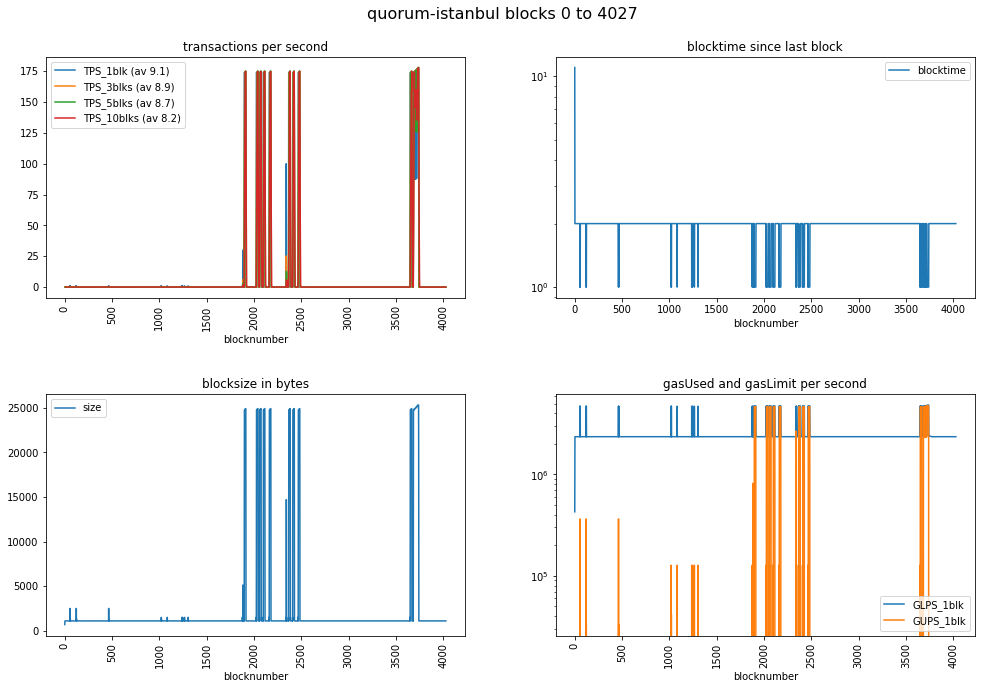

In [ ]:
# the whole range of blocks

diagrams(df, 0, len(blocknumbers)-1, "quorum-istanbul", gas_logy=True, bt_logy=True)

<a id='experiment1'>experiment 1 - all 4 diagrams in one</a>

# final experiment, blocks ~3680 to ~3740


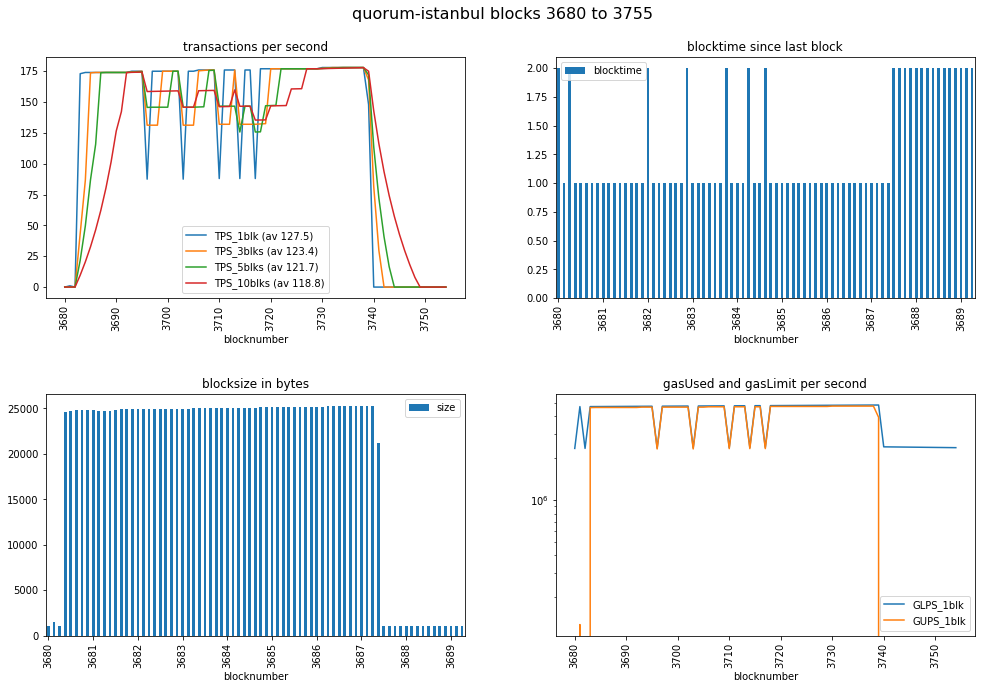

In [ ]:
# starting only at block 3 because the waiting time before experiment start created a 100s *blocktime*

diagrams(df, 3680, 3755, "quorum-istanbul", gas_logy=True, bt_logy=False)